# Zillow Single Family Home Prediction Model

## Goals 

### Provide insight into variables driving the value of Single Family Homes homes based on transactions that occured in 2017

### Develop a model that performs better than our baseline model

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import pandas as pd
from scipy import stats
from pydataset import data
import numpy as np
import env
import matplotlib.pyplot as plt
import os
import prepare
import acquire
import seaborn as sns
import explore
from math import sqrt
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoLars
from sklearn.linear_model import TweedieRegressor

# Data Acquisition and Preparation
## Zillow 2017, Single Family Home data was acquired via SQL query

In [2]:
df = acquire.get_zillow_sfr_data()
df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
bedroomcnt,4.0,3.0,3.0,3.0,4.0
bathroomcnt,2.0,2.0,2.0,2.0,3.0
calculatedfinishedsquarefeet,1696.0,1470.0,1450.0,1694.0,2578.0
taxvaluedollarcnt,252549.0,512000.0,229856.0,294026.0,426407.0
yearbuilt,1960.0,1957.0,1957.0,1957.0,1963.0
fips,6037.0,6037.0,6037.0,6037.0,6037.0
transactiondate,2017-01-13,2017-01-13,2017-01-13,2017-01-13,2017-01-13


## Null Values:
    250 results were eliminated from the set for null values
## Naming Conventions
    Column names were modified for clarity
## Outliers Removed
    All datapoints outside of 5 standard deviations removed
## Dataset Split into Training, Validating, and Testing Sets

In [4]:
train, val, test = prepare.clean_prep_zillow(df)
train.shape

(38619, 6)

In [5]:
train.head().T

,11547,29091,19611,24109,45109
bedroom,3.0,2.0,3.0,2.0,3.0
bathroom,2.0,1.0,2.0,1.0,2.0
sqrft,1659.0,1070.0,1085.0,1112.0,1316.0
tax_value,236760.0,360606.0,341328.0,372312.0,381638.0
year_built,1958.0,1920.0,1993.0,1949.0,1949.0
fips,6037.0,6037.0,6059.0,6037.0,6037.0


# Exploration
## Intial Questions Guiding Exploration
### -Does square footage influence value?
### -Is the tax value dependent on the number of bathrooms?
### -Is Tax value dependent on FIPS?
### -Is Tax value dependent on the number of bedrooms?


# Square Footage and Taxable Value

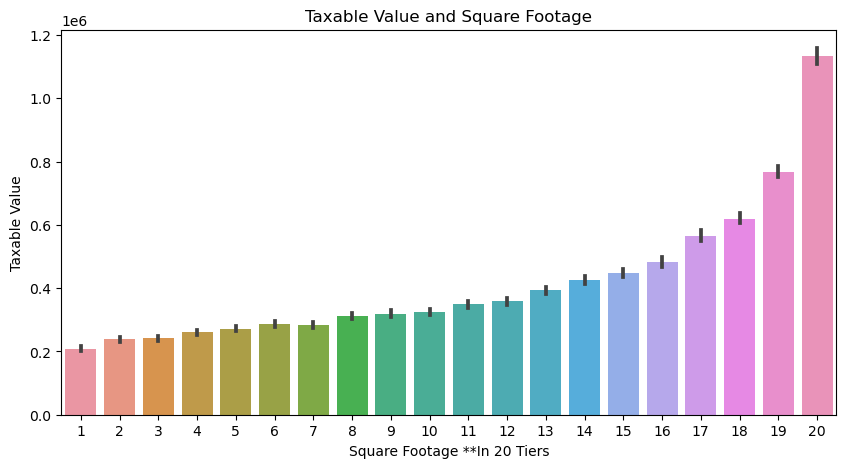

In [23]:
train['sqft_bin'] = pd.qcut(train['sqrft'], 20, labels = ['1','2','3','4','5','6',
                                                          '7','8','9','10','11','12','13','14','15',
                                                         '16','17','18','19','20'])

plt.figure(figsize=(10,5))
plt.title('Taxable Value and Square Footage')

sns.barplot(data=train, x="sqft_bin", y="tax_value")
plt.xlabel('Square Footage **In 20 Tiers')
plt.ylabel('Taxable Value')
plt.show()

In [24]:
alpha = 0.05

v_vs_sf = stats.spearmanr(train.tax_value, train.sqrft)
v_vs_sf

SpearmanrResult(correlation=0.5151300732092542, pvalue=0.0)

## Analysis
### -Is there a correlation between tax value and sqrft?
    Null: There is no correlation between tax value and sqrft
    Alternate: There is a significant correlation between tax value and sqrft
### -Spearman Correlation test strongly supports a correlation between Square Footage and Taxable Value

# Number of Bathrooms and Taxable Value

Text(0, 0.5, 'Taxable Value')

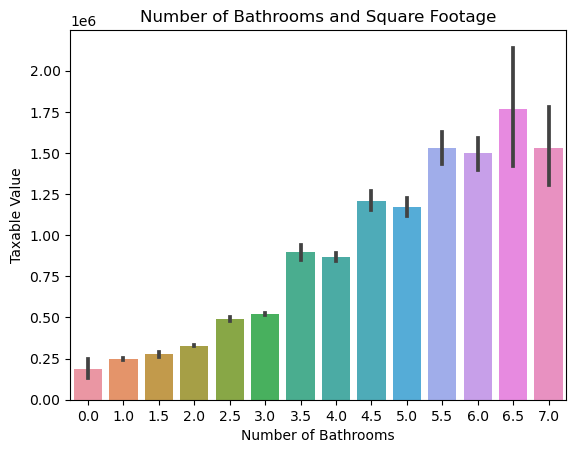

In [39]:


plt.title('Number of Bathrooms and Square Footage')
sns.barplot(data=train, x="bathroom", y="tax_value")

plt.xlabel('Number of Bathrooms')
plt.ylabel('Taxable Value')


## Is the tax value dependent on the number of bathrooms?
    Null: Tax value and the number of bathrooms are independent of one another.
    Alternate: The two values are dependent on each other.

In [41]:
stats.ttest_ind(train.tax_value, train.bathroom, alternative = 'two-sided')

Ttest_indResult(statistic=228.74788437149323, pvalue=0.0)

### -T-Test Correlation test strongly supports a correlation between Square Footage and Taxable Value


# FIPS and Tax Value

Text(0, 0.5, 'Taxable Value')

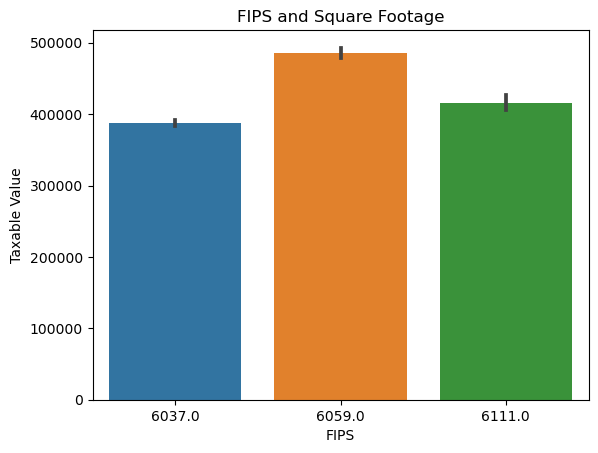

In [45]:
plt.title('FIPS and Square Footage')
sns.barplot(data=train, x="fips", y="tax_value")

plt.xlabel('FIPS')
plt.ylabel('Taxable Value')

In [46]:
stats.ttest_ind(train.tax_value, train.fips, alternative = 'two-sided')

Ttest_indResult(statistic=225.4111346543803, pvalue=0.0)

### -T-Test Correlation test strongly supports a correlation between FIPS and Taxable Value

# Number of Bedrooms and Taxable Value

Text(0, 0.5, 'Taxable Value')

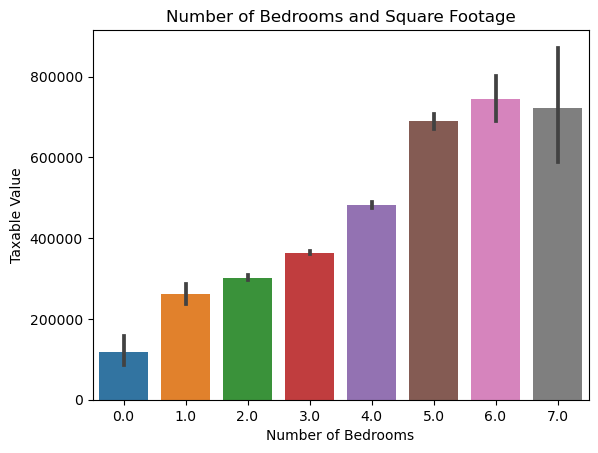

In [47]:
plt.title('Number of Bedrooms and Square Footage')
sns.barplot(data=train, x="bedroom", y="tax_value")

plt.xlabel('Number of Bedrooms')
plt.ylabel('Taxable Value')

## Is Tax value dependent on the number of bedrooms?
    Null: No, tax value is independent of the number of bedrooms
    Alternate: Yes, there is a dependency between the two values

In [48]:
stats.ttest_ind(train.tax_value, train.bedroom, alternative = 'two-sided')

Ttest_indResult(statistic=228.74729028221427, pvalue=0.0)

# Modeling

## Square Footage was Scaled 
    to Reduce Errors from Large Integers
## Dummy Variables Created
    to ready data for model analysis